In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import numpy as np
from albumentations.core.composition import Compose
from albumentations.core.bbox_utils import denormalize_bbox, convert_bbox_to_albumentations, convert_bbox_from_albumentations

from typing import List, Union, Tuple
from tqdm import tqdm
import os
import shutil
import random

In [2]:
def get_transforms():
    return Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MotionBlur(p = 0.3),
        A.BBoxSafeRandomCrop(p=1)
    ], bbox_params=A.BboxParams(format='albumentations'))


def augment(image,bbox,transform):
    items = transform(image = image, bboxes = bbox)
    image = items['image']

    bbox = items['bboxes'][0]
    return image, bbox

In [3]:
def read_yolo_annotation_text_file(file_path: str) -> str:
    with open(file_path) as f:
        content = f.read()
    return content if content else None

def get_bbox_from_yolo_text_data(coco_text_data: str) -> List[Union[float, int]]:
    bbox = coco_text_data.split(' ')
    return list(map(float, bbox[1:])) + [int(bbox[0])]

def save_bbox_info_in_yolo_text_file(bbox: List[Union[float, int]],
                                     img_shape: tuple,
                                    file_path: str) -> None:
    bbox_info_yolo_format = convert_bbox_from_albumentations(bbox, target_format='yolo', \
                                          rows=img_shape[0], cols=img_shape[1])
    bbox_info_yolo_format = [str(bbox_info_yolo_format[-1])] + list(map(str, bbox_info_yolo_format[:-1])) 
    bbox_info_text = ' '.join(bbox_info_yolo_format)
    
    with open(file_path, 'w') as file:
        file.write(bbox_info_text)
        
def save_image(img: np.array, file_path: str) -> None:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(file_path, img)
    

def read_image(image_path: str) -> np.array:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_rectangular_corner_points(bbox: List[float]) -> Tuple[Tuple[int]]:
    
    top_left_point = (round(bbox[0]), round(bbox[1]))
    bottom_right_point = (round(bbox[2]), round(bbox[3]))
    
    return top_left_point, bottom_right_point

def correct_bbox_coordinates(bbox: List[float]) -> List[float]:
    bbox_info = [0.0001 if bbox_item < 0 else bbox_item for bbox_item in bbox]
    bbox_info = [1 if bbox_item > 1 else bbox_item for bbox_item in bbox_info]
    return bbox_info

def draw_bbox_on_image(image: np.array, 
                              bbox: List[float],
                             change_bbox_format: bool=False,
                             color: tuple = (255, 0, 0),
                             thickness: int = 2) -> None:
    
    img_shape = image.shape
    
    if change_bbox_format:
        bbox = convert_bbox_to_albumentations(bbox, source_format='yolo', \
                                          rows=img_shape[0], cols=img_shape[1])
    unnormalized_bbox_parameters = denormalize_bbox(bbox, img_shape[0], img_shape[1])
    top_left_point, bottom_right_point = get_rectangular_corner_points(unnormalized_bbox_parameters)
    image_with_rect = image.copy()
    
    cv2.rectangle(img=image_with_rect, 
                  pt1=top_left_point,
                  pt2=bottom_right_point,
                  color=color,
                  thickness=thickness)
    
    return image_with_rect

def create_augmented_image(img_path: str, yolo_annotation_path: str) -> (np.array, List):
    bbox_info_string = read_yolo_annotation_text_file(yolo_annotation_path)
    img = read_image(img_path)
    bbox_info = get_bbox_from_yolo_text_data(bbox_info_string)
    bbox_info = convert_bbox_to_albumentations(bbox_info, source_format='yolo', \
                                          rows=img.shape[0], cols=img.shape[1])
    bbox_info = correct_bbox_coordinates(bbox_info)
    
    transform = get_transforms()
    image_transformed, bbox_transformed = augment(image=img, bbox=[bbox_info], transform=transform)
    
    return image_transformed, bbox_transformed


def create_new_name_for_file(file_name: str, inserted_text: str) -> str:
    
    return os.path.splitext(file_name)[0] + inserted_text + os.path.splitext(file_name)[1]


def save_new_augmented_image_with_annotation(src_img_path: str,
                                        src_annotation_path: str,
                                        dest_img_path: str,
                                        dest_annotation_path: str) -> None:
    
    image_transformed, bbox_transformed = create_augmented_image(src_img_path, src_annotation_path)
    
    save_bbox_info_in_yolo_text_file(bbox_transformed, image_transformed.shape, dest_annotation_path)
    save_image(image_transformed, dest_img_path)
    
def save_multiple_augmented_images_with_annotations(src_img_path: str,
                                                   src_annotation_path: str,
                                                   dest_img_folder: str,
                                                   dest_annotation_folder: str, 
                                                   num_of_augmented_images: int = 10) -> None:

    src_img_name = os.path.basename(src_img_path)
    src_annotation_file_name = os.path.basename(src_annotation_path)
    
    final_src_img_name = create_new_name_for_file(src_img_name, '_0')
    final_src_annotation_file_name = create_new_name_for_file(src_annotation_file_name, '_0')
    
    shutil.copy(src_img_path, os.path.join(dest_img_folder, final_src_img_name))
    shutil.copy(src_annotation_path, os.path.join(dest_annotation_folder, final_src_annotation_file_name))

    if read_yolo_annotation_text_file(src_annotation_path) is not None:
    
        for image_num in range(num_of_augmented_images):
            img_name = create_new_name_for_file(src_img_name, '_'+str(image_num+1))
            annotation_file_name = create_new_name_for_file(src_annotation_file_name, '_'+str(image_num+1))

            dest_img_path = os.path.join(dest_img_folder, img_name)
            dest_annotation_path = os.path.join(dest_annotation_folder, annotation_file_name)
            save_new_augmented_image_with_annotation(src_img_path, 
                                                    src_annotation_path,
                                                    dest_img_path, 
                                                    dest_annotation_path)
        
def create_augmented_images_from_sources_in_folder(src_img_folder_path: str,
                                                  src_annotation_folder_path: str,
                                                  dest_img_folder_path: str,
                                                  dest_annotation_folder_path: str,
                                                  num_of_augmented_images: int = 10) -> None:
    os.makedirs(dest_img_folder_path, exist_ok=True)
    os.makedirs(dest_annotation_folder_path, exist_ok=True)   
    
    list_of_images = sorted(os.listdir(src_img_folder_path))
    list_of_annotation_files = sorted(os.listdir(src_annotation_folder_path))
    
    for image_num, image in enumerate(list_of_images):
        src_img_path = os.path.join(src_img_folder_path, image)
        src_annotation_path = os.path.join(src_annotation_folder_path ,list_of_annotation_files[image_num])
        
        save_multiple_augmented_images_with_annotations(src_img_path, 
                                                        src_annotation_path,
                                                        dest_img_folder_path,
                                                        dest_annotation_folder_path,
                                                        num_of_augmented_images
                                                       )
        
def create_augmented_images_from_sources_in_multiple_folders(src_images_folders_path: str,
                                                            src_annotations_folders_path: str,
                                                            dest_images_folders_path: str,
                                                            dest_annotations_folders_path: str,
                                                            num_of_augmented_images: int = 10) -> None:
    os.makedirs(dest_images_folders_path, exist_ok=True)
    os.makedirs(dest_annotations_folders_path, exist_ok=True)   
    
    
    list_of_images_folders = sorted(os.listdir(src_images_folders_path))
    for image_folder in tqdm(list_of_images_folders, desc ="Folders processed"):
        src_img_folder_path = os.path.join(src_images_folders_path, image_folder)
        dest_img_folder_path = os.path.join(dest_images_folders_path, image_folder)
        src_annotation_folder_path = os.path.join(src_annotations_folders_path, image_folder)
        dest_annotation_folder_path = os.path.join(dest_annotations_folders_path, image_folder)
         
        create_augmented_images_from_sources_in_folder(src_img_folder_path,
                                                      src_annotation_folder_path,
                                                      dest_img_folder_path,
                                                      dest_annotation_folder_path,
                                                      num_of_augmented_images)

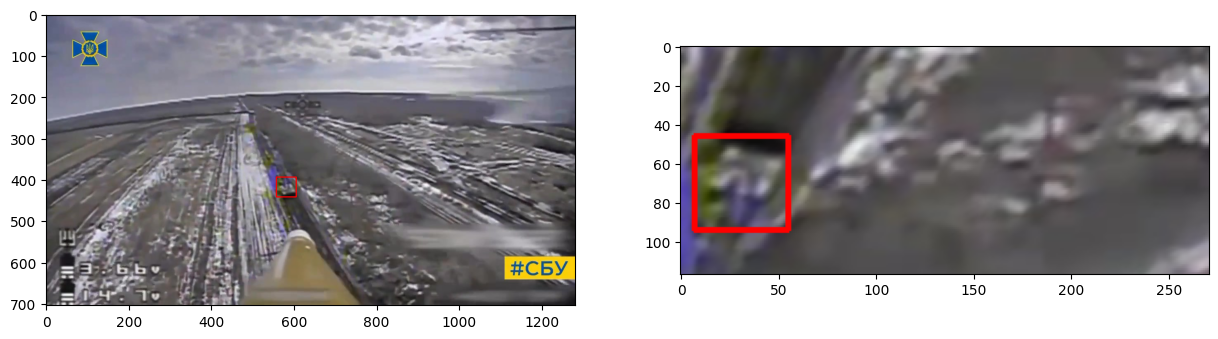

In [4]:
#===========================TESTING===============================================
test_image_path = '/home/vlad/Videos/Project 1-20230401T062938Z-001/data_to_process/images/291426519_IMG_3353_2_mp4/291426519_IMG_3353_2_mp4_291426519_frame_000540.jpg'
test_annotation_file_path = '/home/vlad/Videos/Project 1-20230401T062938Z-001/data_to_process/labels/291426519_IMG_3353_2_mp4/291426519_IMG_3353_2_mp4_291426519_frame_000540.txt'

bbox = read_yolo_annotation_text_file(test_annotation_file_path)
img = read_image(test_image_path)
bbox_info = get_bbox_from_yolo_text_data(bbox)

image_transformed, bbox_transformed = create_augmented_image(test_image_path, test_annotation_file_path)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(draw_bbox_on_image(img, bbox_info[:-1], change_bbox_format=True))
ax[1].imshow(draw_bbox_on_image(image_transformed, bbox_transformed[:-1]))

In [5]:
init_images_path = '/home/vlad/Videos/Project 1-20230401T062938Z-001/data_to_process/images'
init_annotations_path = '/home/vlad/Videos/Project 1-20230401T062938Z-001/data_to_process/labels'
transformed_images_path = '/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder images'
transformed_annotations_path = '/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder labels'

In [7]:
create_augmented_images_from_sources_in_multiple_folders(init_images_path,
                                                         init_annotations_path,
                                                         transformed_images_path,
                                                         transformed_annotations_path)

Folders processed: 100%|████████████████████████| 70/70 [05:13<00:00,  4.47s/it]


In [6]:
def pick_random_image_for_visualization(transformed_images_path: str,
                                        transformed_annotations_path: str) -> None:
    
    list_of_images_folders = sorted(os.listdir(transformed_images_path))
    
    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    
    for i in range(4):
        random_folder = random.choice(list_of_images_folders)    

        list_of_images = sorted(os.listdir(os.path.join(transformed_images_path, random_folder)))
        list_of_annotation_files = sorted(os.listdir(os.path.join(transformed_annotations_path, random_folder)))

        random_index = random.randint(0, len(list_of_images)-1)

        random_image = list_of_images[random_index]
        random_annotation = list_of_annotation_files[random_index]

        image_path = os.path.join(transformed_images_path, random_folder, random_image)
        annotation_path = os.path.join(transformed_annotations_path, random_folder, random_annotation)
        print(image_path+'\n')
        if read_yolo_annotation_text_file(annotation_path) is not None:
            image, bbox = create_augmented_image(image_path, annotation_path)
        
            axs.flatten()[i].imshow(draw_bbox_on_image(image, bbox[:-1]))
        else:  
            print(f"Image {random_image} don't have bboxes")
    plt.show()

/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder images/ds0_011_291412659/ds0_011_291412659_frame_000050_4.jpg

/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder images/291426518_IMG_3691_3_mp4/291426518_IMG_3691_3_mp4_291426518_frame_000140_6.jpg

/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder images/291426538_Azerbaijani loitering munition strikes on Armenian forces._1_mp4/291426538_Azerbaijani loitering munition strikes on Armenian forces._1_mp4_291426538_frame_000155_8.jpg

/home/vlad/Документы/material_for_practice/CV_Coursera_courses/test folder images/291246744_trench_shiny_field_20m_60_mp4/291246744_trench_shiny_field_20m_60_mp4_291246744_frame_000040_9.jpg



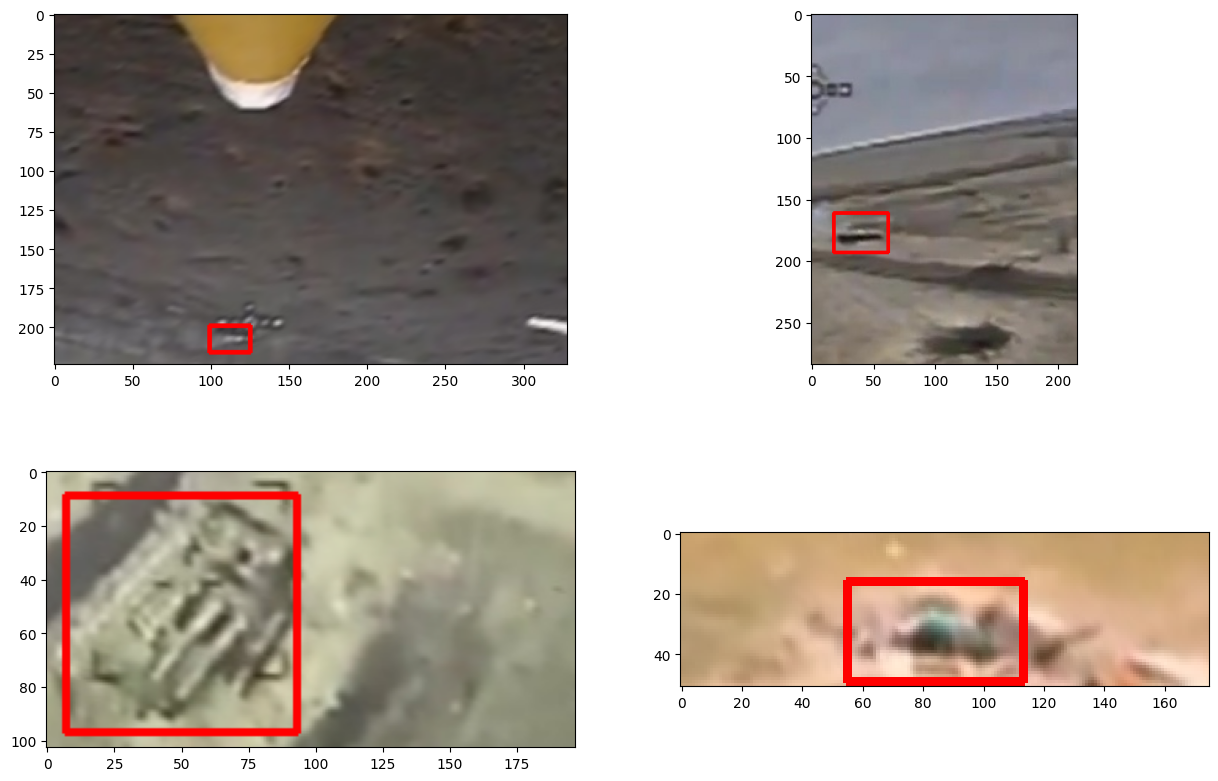

In [10]:
pick_random_image_for_visualization(transformed_images_path, transformed_annotations_path)